# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras

from tqdm import tqdm
from math import ceil
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator
from preprocess import ProdKernel, FKernel, Preprocess, Zero_One,  Level_Normalizer, Normalizer
from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  CST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime

from preprocess import ProdKernel, FKernel, DictPrepross, Level_Normalizer
from utils import Load_FLX_dict, Plot_Batch
from generator import Diff_Generator, Up_and_Down_Generator

##### Dictionnary
D2 = []
D2 = [DictPrepross(['o3','pl'], [Level_Normalizer(False),Level_Normalizer(False)] )]
D = [Load_FLX_dict()]
##### Kernels
Klist = []
fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=512, train=True, preprocess_x=D)
D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
##### Full Preprocessing :
FP = D + D2 #+ Klist
##### b_size
batch_size= 64

train_generator =  Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP)
validation_generator =  Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=False, preprocess_x=FP, custom_b_p_e = 50)

header_x = train_generator.variables
header_y = train_generator.new_variables_pred

In [32]:
# NEW MODEL :
from keras.layers import Input, Conv1D, SeparableConv1D
from keras.models import Sequential



inputs2 = Input(shape=(72,11))
Conv2 = SeparableConv1D(filters=6, kernel_size=5, padding='same', use_bias=True)(inputs2)
Model2 = keras.Model(inputs2, Conv2)
Model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 72, 11)            0         
_________________________________________________________________
separable_conv1d_9 (Separabl (None, 72, 6)             127       
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________


In [34]:
11*(5+6)+6

127

In [25]:
inputs = Input(shape=(72,11))
Conv1 = Conv1D(filters=5   , kernel_size=5, padding='same', use_bias=False)(inputs)
Model = keras.Model(inputs, Conv1)
Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 72, 11)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 72, 5)             275       
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


In [26]:
5*5*11

275

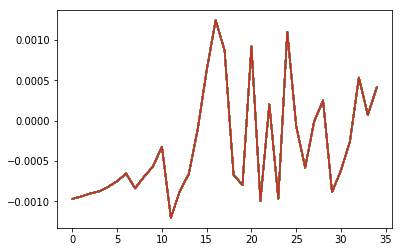

In [5]:
x[:,:,3]-=Lv_n.L
plt.plot( np.log(x[:,:35,3].T);

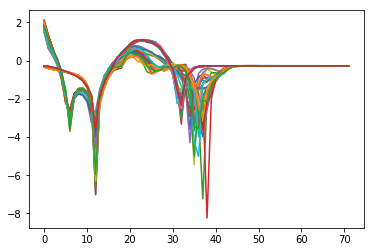

In [16]:
plt.plot(np.log(abs(x[:,:,2])).T);

In [6]:
from architectures import Classical_Bidir, Old_Bidir, Add_Upsampling, Upsampler
from architectures import flxd_loss, flxu_loss, dfdts_loss, total_loss
from architectures import Weird_Averaged_Bidir, Averaged_Bidir
from keras import optimizers
import keras.backend as K

n_channel = len(train_generator.variables)
o_channel = len(train_generator.new_variables_pred)
shape = (72,n_channel)

m_old = Old_Bidir()

model_bd = Weird_Averaged_Bidir(in_channel=n_channel, out_channel=o_channel)
model_bd_2 = Add_Upsampling(model_bd, shape, 5, 26)

model_bd_avg = Averaged_Bidir(in_channel=n_channel, out_channel=o_channel)
model_bd_avg_2 = Add_Upsampling(model_bd_avg, shape, 5, 26)


model_bd_2.summary()
model_bd_avg_2.summary()

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1.e-5)
model_bd_2.compile(loss=total_loss, optimizer=rmsprop,  metrics=[flxd_loss,flxu_loss, dfdts_loss])
model_bd_avg_2.compile(loss=total_loss, optimizer=rmsprop,  metrics=[flxd_loss,flxu_loss, dfdts_loss])

prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = "Bidir"
model_bd.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:80: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(7, padding="same", strides=1)`
  modelbd.add(AveragePooling1D(7, padding='same', stride=1))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:83: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(4, padding="same", strides=1)`
  modelbd.add(AveragePooling1D(4, padding='same', stride=1))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:94: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(26, padding="same", strides=5)`
  M.add(AveragePooling1D(pooling, padding='same', stride=avg))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:66: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(7, padding="same", strides=1)`
  modelbd.add(AveragePooling1D(7, padd

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 72, 11)            0         
_________________________________________________________________
Upsampler (Sequential)       (None, 72, 11)            0         
_________________________________________________________________
Sequential_1 (Sequential)    (None, 72, 3)             260369    
Total params: 260,369
Trainable params: 260,369
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 72, 11)            0         
_________________________________________________________________
Upsampler (Sequential)       (None, 72, 11)            0         
_________________________________________________________________
Sequ

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D
from keras.layers import Bidirectional
from keras.losses import mean_squared_error


Model0_w = os.path.join(model_folder,'20190514234805Bidir.h5')  # Old one
Model1_w = os.path.join(model_folder,'20190515175543Bidir.h5') # With not so weird avg
Model2_w = os.path.join(model_folder,'20190515213039_2Bidir.h5') # 2 epoch "normal" avg

# Only one part was loaded
m_old.load_weights(Model0_w)
m_old_2 = Add_Upsampling(m_old, shape, 5, 26)

model_bd.load_weights(Model1_w)
model_bd_avg_2.load_weights(Model2_w)

# OK
model_bd_2 = Add_Upsampling(model_bd, shape, 5, 26)

### VISUALISATION OF A FEW PREDICTION

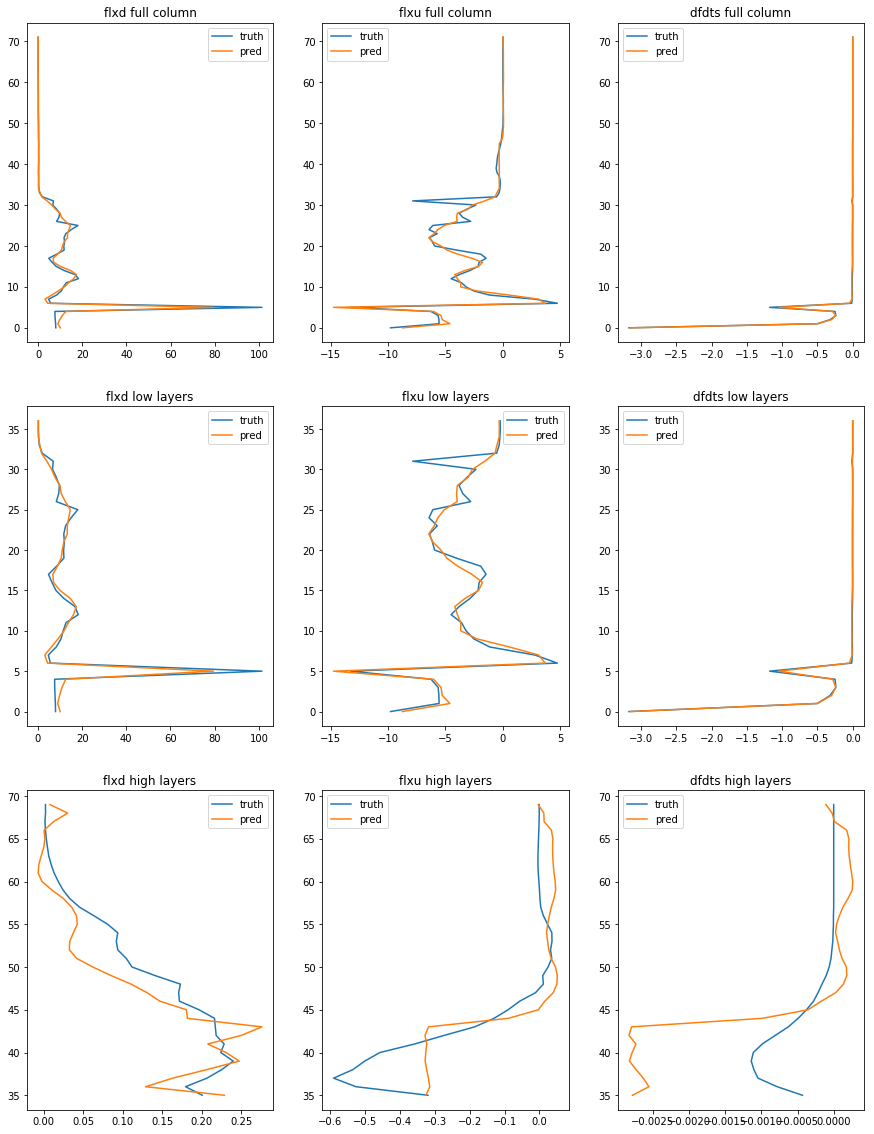

<Figure size 1080x576 with 0 Axes>

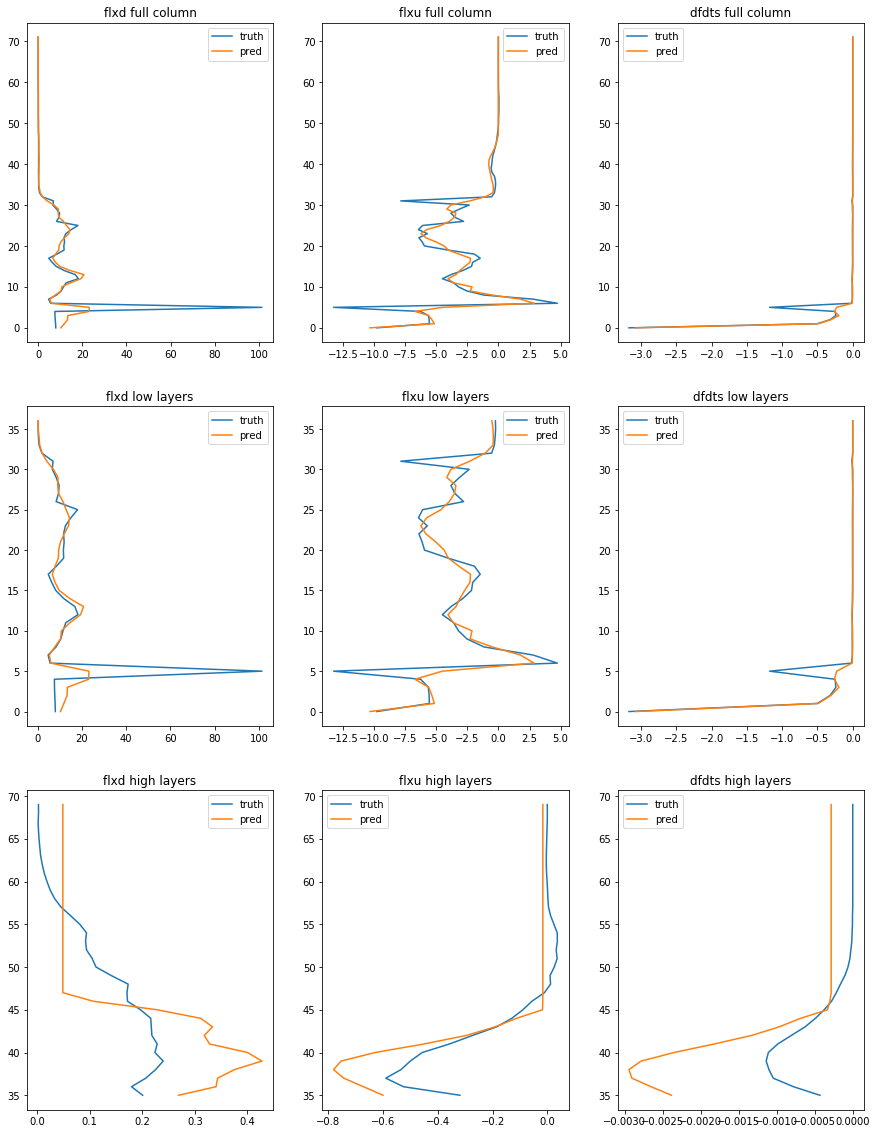

<Figure size 1080x576 with 0 Axes>

In [64]:
from utils import Plot_Batch, Plot_Histograms, Plot_triple_diff_separated, F_and_plots

x,y = validation_generator[10]
#x_t = K.placeholder(shape=(64,72,11))
y0 = model_bd_avg_2.predict(x)
y1 = model_bd_2.predict(x)

Plot_triple_diff_separated(F_and_plots((3,3), figsize=(15,20)), y,y0, header_y, sep=35, j=0)
Plot_triple_diff_separated(F_and_plots((3,3), figsize=(15,20)), y,y1, header_y, sep=35, j=0)

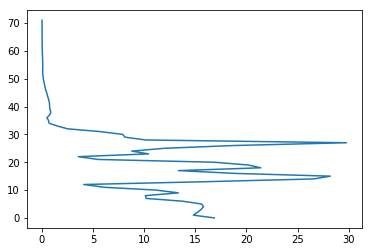

In [49]:
from generator import Full_Diff_Generator
FDG = Full_Diff_Generator(chosen_var=['flxu', 'flxd', 'dfdts', 'flx'])
x,y = FDG[0]

def Plot_one_profile(y):
    plt.plot(np.flip(y).T, np.arange(len(y[0])) )
    plt.show()

Plot_one_profile( y[[1],:,1] -y[[1],:,0])

### GRADIENT USE

In [51]:
# Compute df/dts for the batch x_test

x_test,y = validation_generator[0]
k_constants = K.constant(x_test[:,:,:-1])
input11 = keras.layers.Input(batch_shape=(64,1))
input12 = keras.layers.RepeatVector(n=72)(input11)
out11 = keras.layers.Lambda(lambda x: K.concatenate([x,k_constants],axis=-1))(input12)
out12 = model_bd_avg_2(out11)
out13 = keras.layers.Lambda(lambda y: y[:,:,1] - y[:,:,0])(out12)
model1 = keras.models.Model(inputs=input11, outputs=out13)
model1.summary()
###
import time
t=time.time()
gradients = [K.gradients(model1.get_output_at(0)[:,i], model1.input) for i in range(72)]
grad0 = K.function( [model1.input] , [gradients[i][0] for i in range(72)] )
ts = x_test[:,0,-1].reshape(x_test.shape[0], 1)
g = np.array(grad0([ts]))
g = g.swapaxes(0,1)
print(time.time()-t)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 1)                   0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (64, 72, 1)               0         
_________________________________________________________________
lambda_1 (Lambda)            (64, 72, 11)              0         
_________________________________________________________________
model_2 (Model)              multiple                  260369    
_________________________________________________________________
lambda_2 (Lambda)            (64, 72)                  0         
Total params: 260,369
Trainable params: 260,369
Non-trainable params: 0
_________________________________________________________________
119.60348534584045


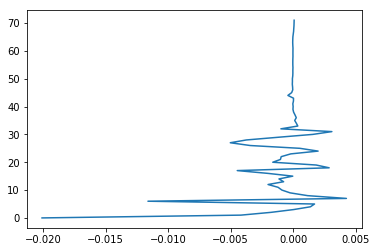

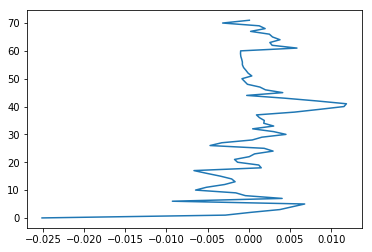

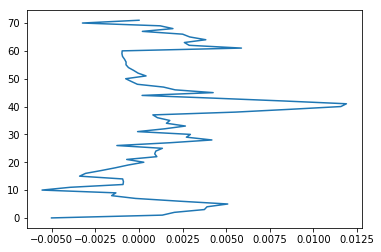

In [52]:
x_test_delta_t = x_test.copy()
delta_t = 0.001

x_test_delta_t[:,:,-1] += delta_t

y_0 = model_bd_avg_2.predict(x_test)
y_delta = model_bd_avg_2.predict(x_test_delta_t)

flx = y_0[:,:,1] - y_0[:,:,0]
flx_delta = y_delta[:,:,1] - y_delta[:,:,0]
j=[5]
DF = flx_delta[j] - flx[j]
Plot_one_profile(DF)
Plot_one_profile(DF - g[j,:,0]*delta_t)
Plot_one_profile(-g[j,:,0]*delta_t)

In [110]:
#flx[[1]].shape
g.shape

(64, 72, 1)

In [46]:
x,y = validation_generator[50]
x_t = K.placeholder(shape=(64,72,11))
y1 = mold.predict(x)
y2 = mold2.predict(x)
y3 = modelbd.predict(x)
y4 = modelbd2.predict(x)

Show_triple_diff_separated(F_and_plots((3,3), figsize=(15,20)), y,y4, header_y, sep=35, j=0)

NameError: name 'mold' is not defined

In [8]:
x,y = validation_generator[1]
x_t = K.placeholder(shape=(64,72,11))
y1 = mold.predict(x)
y2 = mold2.predict(x)
y3 = modelbd.predict(x)
y4 = modelbd2.predict(x)

In [9]:
x,y = validation_generator[np.random.randint(500)]

input1 = modelbd2.input
output1 = modelbd2.layers[1].get_output_at(-1)
#output = modelbd2.layers[0].output
#input2 = modelbd2.layers[0].input
outputs = modelbd.layers[0].output

functor = K.function( [input1], [outputs] )
functor([x_t])

InvalidArgumentError: You must feed a value for placeholder tensor 'Bidir_input' with dtype float and shape [?,72,11]
	 [[Node: Bidir_input = Placeholder[dtype=DT_FLOAT, shape=[?,72,11], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Bidir/concat/_205 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_414_Bidir/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [57]:
x, y = validation_generator[40]
get_bidir_layer_output = K.function([model_bd_avg.layers[0].input],
                                  [model_bd_avg.layers[0].output])

X=[x.copy()]
for i in range(11):
    X.append(x.copy())
    X[i] *= 0
    X[i][:,:,i] = x[:,:,i]
#    if(i==3):
#        X[i][:,:41, 3]=0

layer_output = [ get_bidir_layer_output([xi]) for xi in X]

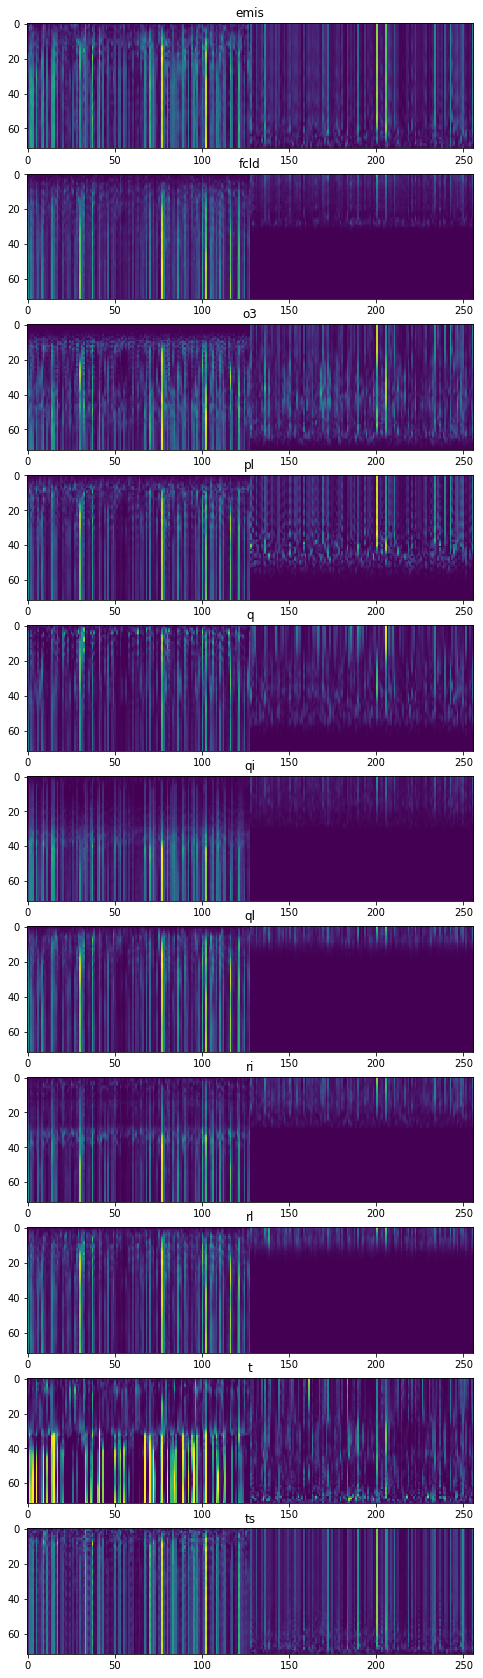

In [58]:
F = F_and_plots(shape=(11,1), figsize=(20, 30))
for i in range(11):    
    img = np.flip(np.mean(abs(layer_output[i][0]), axis=0))
    F[i].set_title(header_x[i])
    F[i].imshow(img)

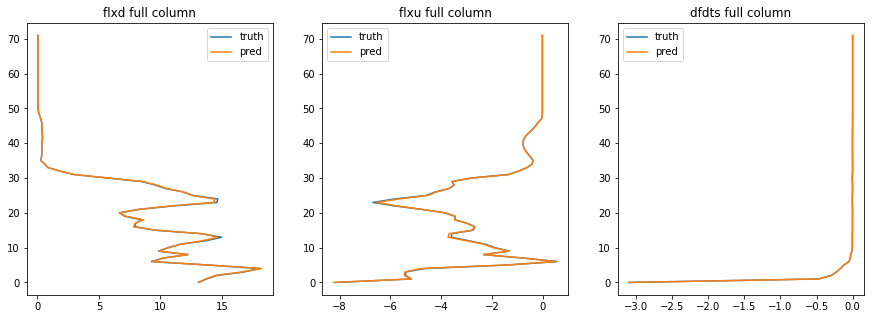

<Figure size 1080x576 with 0 Axes>

In [40]:
x_nop = x.copy(); x_nop[:,:,3]=0
y_nop=model_bd_2.predict(x_nop)
y0=model_bd_2.predict(x)
Plot_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y0, y_nop, header_y, sep=0, j=1)

In [36]:
x_nop

array([[[ 2.5436738e-01,  0.0000000e+00, -1.0324657e-02, ...,
          0.0000000e+00, -2.3891234e+00,  2.5325525e+00],
        [ 2.5436738e-01,  0.0000000e+00, -1.6230881e-02, ...,
          0.0000000e+00, -1.6502517e+00,  2.5325525e+00],
        [ 2.5436738e-01,  0.0000000e+00, -1.9837618e-02, ...,
          0.0000000e+00, -1.1305684e+00,  2.5325525e+00],
        ...,
        [ 2.5436738e-01,  0.0000000e+00,  6.6143274e-04, ...,
          0.0000000e+00,  2.0345442e+00,  2.5325525e+00],
        [ 2.5436738e-01,  0.0000000e+00,  7.7527761e-04, ...,
          0.0000000e+00,  2.0873275e+00,  2.5325525e+00],
        [ 2.5436738e-01,  0.0000000e+00,  7.7491999e-04, ...,
          0.0000000e+00,  2.1407304e+00,  2.5325525e+00]],

       [[ 2.5436738e-01,  0.0000000e+00, -1.7857552e-02, ...,
          0.0000000e+00, -2.3975399e+00,  2.5652375e+00],
        [ 2.5436738e-01,  0.0000000e+00, -7.9177022e-03, ...,
          0.0000000e+00, -1.1363035e+00,  2.5652375e+00],
        [ 2.5436738e-01, 

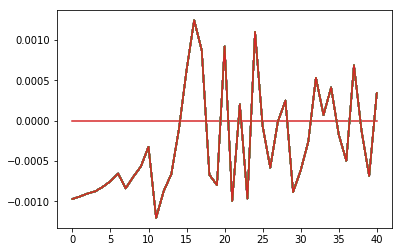

In [28]:
plt.plot(X[3][:,:41,3].T);

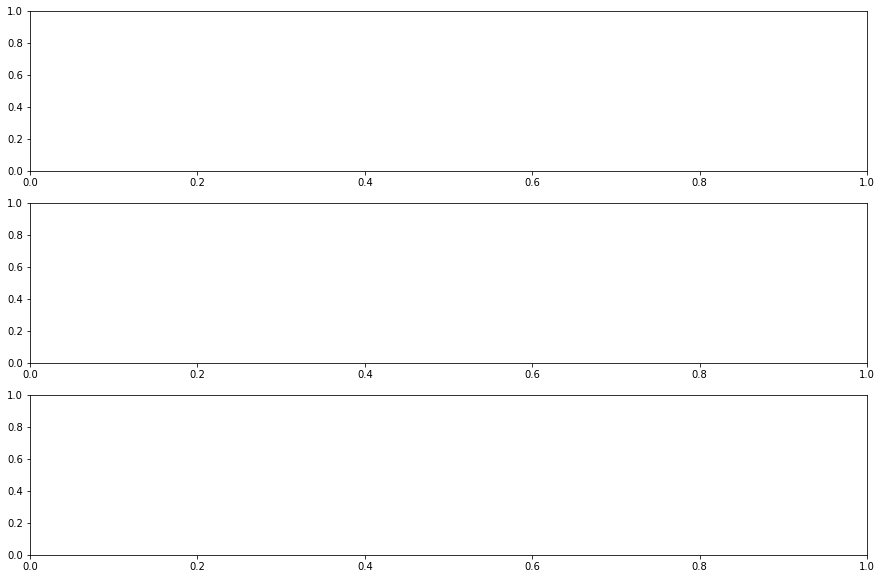

In [336]:
x1,_ = validation_generator[80]
x2,_ = validation_generator[50]
x3,_ = validation_generator[3]
F = F_and_plots(shape=(3,1))
#plt.plot(x1[:,:35,3].T);
#plt.plot(x2[:,:35,3].T);
#plt.plot(x3[:,:35,3].T);
#plt.plot(L[:35]/len(validation_generator))

In [347]:
n_x = lev_av_g_pl(x1[:,:,3])
n_x.shape

(64, 72)

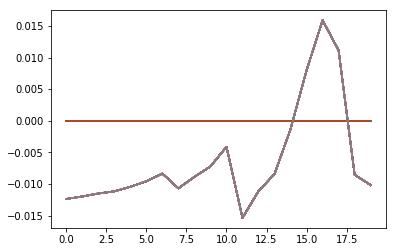

In [359]:
plt.plot(n_x[:,:20].T);
plt.plot(x[:,:20,3].T);

In [362]:
from generator import Preprocessed_Generator
P = Preprocessed_Generator(preprocess_x=D)

In [361]:
D

In [90]:
model_one_dir_up  = keras.models.clone_model(modelbd)
model_one_dir_down  = keras.models.clone_model(modelbd)
for i,layer in enumerate(modelbd.layers):
    model_one_dir_up.layers[i].set_weights(layer.get_weights())
    model_one_dir_down.layers[i].set_weights(layer.get_weights()) 

In [97]:
W = modelbd.layers[1].get_weights()[0]
Set_0_up = np.concatenate( (W[:,:128] , W[:,128:]*0), axis=1)
Set_0_down = np.concatenate( (W[:,:128]*0 ,W[:,128:]), axis=1)
model_one_dir_up.layers[1].set_weights( [Set_0_up])
model_one_dir_down.layers[1].set_weights( [Set_0_down])

In [98]:
x,y = validation_generator[0]
y_p1 = modelbd.predict(x)
y_p2 = model_one_dir_up.predict(x)
y_p3 = model_one_dir_down.predict(x)

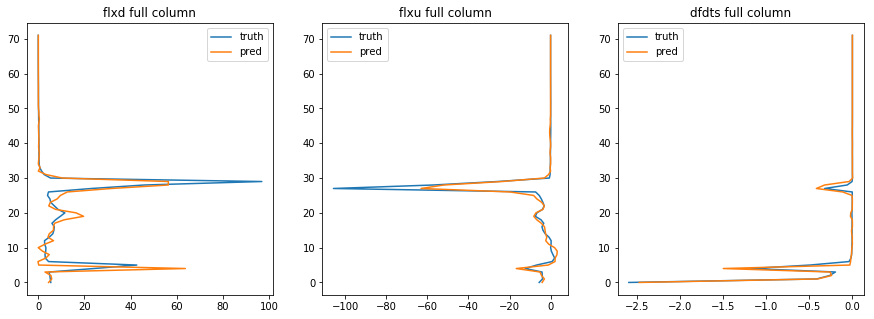

<Figure size 1080x576 with 0 Axes>

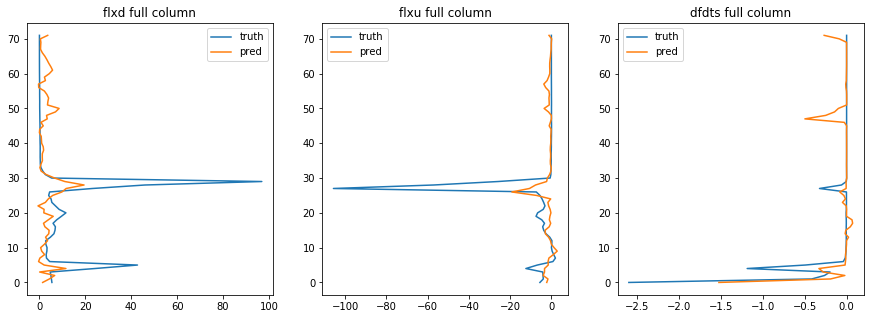

<Figure size 1080x576 with 0 Axes>

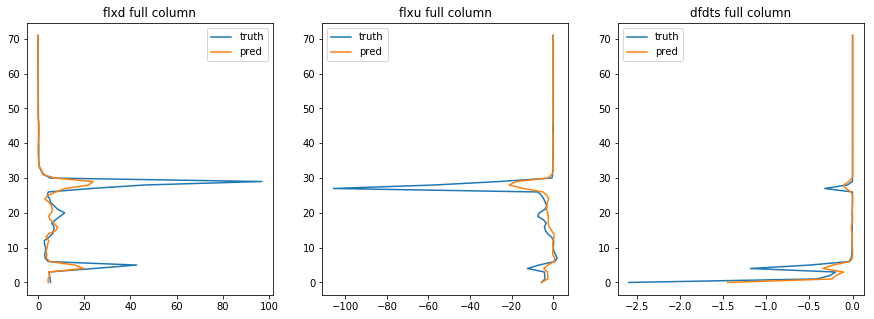

<Figure size 1080x576 with 0 Axes>

In [103]:
Show_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y, y_p1, header_y, sep=0, j=1)
Show_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y, y_p2, header_y, sep=0, j=1)
Show_triple_diff_separated(F_and_plots((1,3), figsize=(15,5)), y, y_p3, header_y, sep=0, j=1)

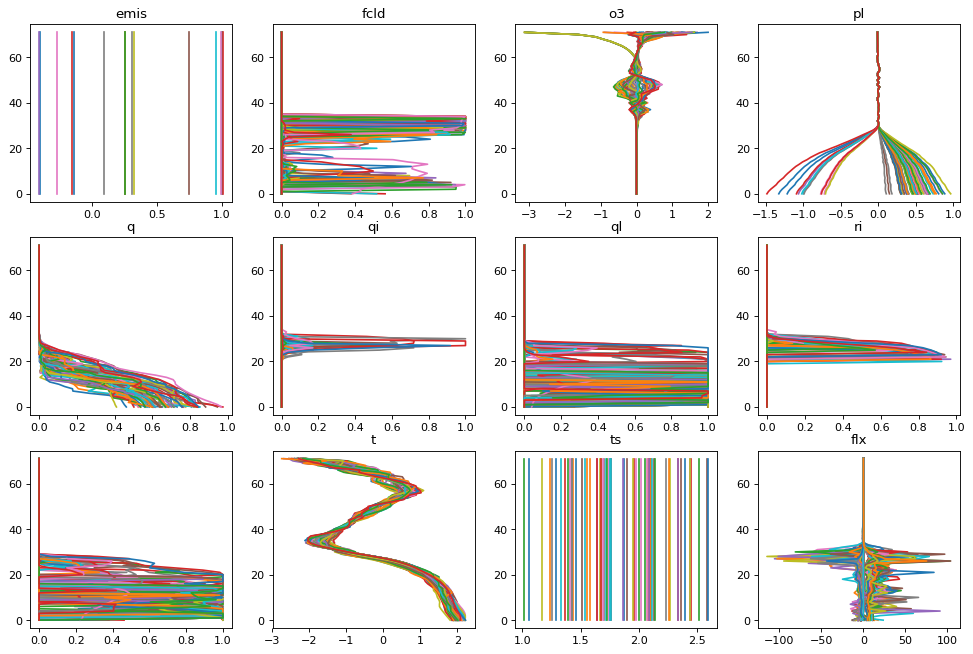

In [67]:
Plot_Batch(x.swapaxes(1,2),y, validation_generator.variables)

In [42]:
class F_and_plots(object):
    def __init__(shape, figsize=(15,10)):
        self.f, self.axes = plt.subplot(shape[0], shape[1], figsize=figsize)
    
    def __getitem__(i):
        return self.axes.flatten()[i]


def Show_triple_diff_separated(y,y0, sep, lev=72, j = 0):
    f = plt.figure( figsize=(15,8) )
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        plt.plot(np.flip(y[:,:,i].T[:sep,j]) , np.arange(sep))
        plt.plot(np.flip(y0[:,:,i].T[:sep,j]) , np.arange(sep))
        ax.legend(["truth", "pred"])
        #
        ax = plt.subplot(1,3,i+1)
        plt.plot(np.flip(y[:,:,i].T[sep:,j]) , np.arange(lev-sep))
        plt.plot(np.flip(y0[:,:,i].T[sep:,j]) , np.arange(lev-sep))
        ax.legend(["truth", "pred"])

In [ ]:
import matplotlib.pyplot as plt

def multipred(models,x):
    bs = x.shape[0]
    yp = np.zeros((len(models),bs,73))
    for i,model in enumerate(models):
        yp[i,:,:]=model.predict(x)
    return(yp)

testsize = 128*4
for x0,y0 in test_generator( (x,y), batch_size=testsize, nb=1):
    data_test = (x0,y0)

ytruth = data_test[1]
xtest = data_test[0].copy() 
xtest1 = data_test[0].copy() 
xtest2 = data_test[0].copy()
xtest3 = data_test[0].copy()

xtest1 *=0
xtest2[:,:,1] *= 0
xtest3[:,:,2] *= 0

ypred = multipred(models,xtest)
ypred1 = multipred(models,xtest1)
ypred2 = multipred(models,xtest2)
ypred3 = multipred(models,xtest3)

def double_mean_squared(y_true, y_pred):
    fist_loss   =  K.mean(K.square(y_pred - y_true), axis=-1)
    second_loss =  x[:, :1]
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
return K.mean(K.square(first_log - second_log), axis=-1)

